In [1]:
import chess
import numpy as np
import pandas as pd
import tensorflow as tf
import math

In [2]:
abs_path="d:\OneDrive - Indian Institute of Technology Bombay\Study\Events and Activities\Year 2\Seasons of Coding 23\soc23-DeepCarlsen"
TotalPos = pd.read_csv(abs_path+"\dataset\chessDataEval.csv", )
TotalPos

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26
...,...,...
12958030,r1bqkb1r/pp3ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1P...,+6
12958031,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1...,+84
12958032,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1BN2N2/PP2Q...,0
12958033,r2qkb1r/pp1b1ppp/1n2p3/n2pP3/3P1P2/1BN2N2/PP2Q...,+115


In [3]:
def cond(arr):
    pos = arr["FEN"].split()[0]
    res = pos.count('Q')>1 or pos.count('B')>2 or pos.count('N')>2 or pos.count('R')>2 or pos.count('q')>1 or pos.count('b')>2 or pos.count('n')>2 or pos.count('r')>2
    return not res
dataset_raw = TotalPos[TotalPos.apply(cond, axis = 1)]

In [4]:
dataset = dataset_raw.sample(100000)
dataset.reset_index(inplace=True)
dataset = dataset.drop(["index"], axis=1)
dataset

,FEN,Evaluation
0,r2q1rk1/p1p2ppp/2Q1b3/8/2BP4/5N2/PPnN1PPP/R4RK...,+465
1,3n3r/p3kp2/1p1pp2p/2r2P2/2P3R1/1P2N3/P3PK1P/6R...,+74
2,6k1/5ppp/2q1rnn1/3p1N2/bB1P4/4PP1P/2B2QP1/4R1K...,+249
3,5k2/5p2/2R1p3/p3r1p1/2P5/1P6/P4P2/5K2 b - - 0 38,+35
4,r3n1k1/pR6/5qp1/3p1b2/2p5/3PN1P1/PP3Q2/R4K2 b ...,0
...,...,...
99995,r1b2rk1/1ppnq1pp/3p4/p1nPpP2/2P2P2/2N3P1/PP1Q1...,+39
99996,2n5/pp3k2/2p1p3/2P5/3P1P1n/4K1N1/PP3P2/5B2 w -...,+354
99997,6k1/pp3ppp/3b4/2p5/P1P5/B2bP2P/4BPP1/5K2 b - -...,0
99998,8/5p2/6p1/3k4/1p1P1pP1/3K2P1/8/8 w - - 0 46,-1196


In [5]:
#dataset = dataset_raw

In [6]:
def features_global(arr):
    fen = arr if isinstance(arr, str) else arr["FEN"]
    board = chess.Board(fen)
    white_play = (board.turn==chess.WHITE)
    K = board.has_kingside_castling_rights(chess.WHITE)
    k = board.has_kingside_castling_rights(chess.BLACK)
    Q = board.has_queenside_castling_rights(chess.WHITE)
    q = board.has_queenside_castling_rights(chess.BLACK)
    return [int(white_play),int(K), int(k), int(Q), int(q)]

In [7]:
def features_piece(arr):
    def p(symbol):
        return chess.Piece.from_symbol(symbol)
    fen = arr if isinstance(arr, str) else arr["FEN"]
    board = chess.Board(fen)
    pieces_map = chess.Board.piece_map(board)
    emp = [-1,-1]
    piece_num = [0]*14
    piece_w = [emp]*16  # K Q B(light) B(dark) N N R R P P P P P P P P
    piece_b = [emp]*16  # k q b(light) b(dark) n n r r p p p p p p p p
    for (loc, pi) in pieces_map.items():
        if pi== p('k'):
            piece_b[0] = [loc%8,loc//8]
            piece_num[7]+=1
        elif pi== p('q'):
            piece_b[1] = [loc%8,loc//8]
            piece_num[8]+=1
        elif pi== p('b'):
            if((loc%8+loc//8)%2!=0):
                piece_b[2] = [loc%8,loc//8]
                piece_num[9]+=1
            else:
                piece_b[3] = [loc%8,loc//8]
                piece_num[10]+=1
        elif pi== p('n'):
            piece_b[piece_b[4:6].index(emp)+4]=[loc%8,loc//8]
            piece_num[11]+=1
        elif pi== p('r'):
            piece_b[piece_b[6:8].index(emp)+6]=[loc%8,loc//8]
            piece_num[12]+=1
        elif pi== p('p'):
            piece_b[piece_b[8:16].index(emp)+8]=[loc%8,loc//8]
            piece_num[13]+=1

        elif pi== p('K'):
            piece_w[0] = [loc%8,loc//8]
            piece_num[0]+=1
        elif pi== p('Q'):
            piece_w[1] = [loc%8,loc//8]
            piece_num[1]+=1
        elif pi== p('B'):
            if((loc%8+loc//8)%2!=0):
                piece_w[2] = [loc%8,loc//8]
                piece_num[2]+=1
            else:
                piece_w[3] = [loc%8,loc//8]
                piece_num[3]+=1
        elif pi== p('N'):
            piece_w[piece_w[4:6].index(emp)+4]=[loc%8,loc//8]
            piece_num[4]+=1
        elif pi== p('R'):
            piece_w[piece_w[6:8].index(emp)+6]=[loc%8,loc//8]
            piece_num[5]+=1
        elif pi== p('P'):
            piece_w[piece_w[8:16].index(emp)+8]=[loc%8,loc//8]
            piece_num[6]+=1
    result = piece_num+[item for sublist in piece_w for item in sublist]+[item for sublist in piece_b for item in sublist]
    return result


In [8]:
def features_map(arr):
    fen = arr if isinstance(arr, str) else arr["FEN"]
    piece_value = {6:1, 5:9, 3:3, 2:3, 4:5, 1:1}
    #piece_value = {6:0, 5:1340, 3:425, 2:450, 4:680, 1:110}
    board = chess.Board(fen)
    wht = []
    wht_count = []
    blk = []
    blk_count = []
    for sq in chess.SQUARES:   
        attks_white = chess.BaseBoard.attackers(board, chess.WHITE, sq)
        attks_black = chess.BaseBoard.attackers(board, chess.BLACK, sq)
        wht.append(0 if len(attks_white)==0 else min(piece_value[chess.BaseBoard.piece_type_at(board, sq2)] for sq2 in attks_white))
        blk.append(0 if len(attks_black)==0 else min(piece_value[chess.BaseBoard.piece_type_at(board, sq2)] for sq2 in attks_black))
        wht_count.append(len(attks_white))
        blk_count.append(len(attks_black))
    return wht_count+wht+blk_count+blk

In [9]:
def feature_extract(evalPos):
        feat_centric = evalPos.copy().drop(["FEN", "Evaluation"], axis=1)
        feat_global = evalPos.copy().drop(["FEN", "Evaluation"], axis=1)
        feat_map = evalPos.copy().drop(["FEN", "Evaluation"], axis=1)

        col_centric = [ "cwk", "cwq", "cwbl","cwbd","cwn","cwr","cwp",
                "cbk", "cbq", "cbbl","cbbd","cbn","cbr","cbp", 
                'wk_col', 'wk_row', 'wq_col', 'wq_row', 'wbl_col', 'wbl_row', 'wbd_col', 'wbd_row', 'wn1_col', 'wn1_row', 'wn2_col', 'wn2_row', 'wr1_col', 'wr1_row', 'wr2_col', 'wr2_row',
                 'wp1_col', 'wp1_row', 'wp2_col', 'wp2_row', 'wp3_col', 'wp3_row', 'wp4_col', 'wp4_row', 'wp5_col', 'wp5_row', 'wp6_col', 'wp6_row', 'wp7_col', 'wp7_row', 'wp8_col', 'wp8_row',
                'bk_col', 'bk_row', 'bq_col', 'bq_row', 'bbl_col', 'bbl_row', 'bbd_col', 'bbd_row', 'bn1_col', 'bn1_row', 'bn2_col', 'bn2_row', 'br1_col', 'br1_row', 'br2_col', 'br2_row', 
                'bp1_col', 'bp1_row', 'bp2_col', 'bp2_row', 'bp3_col', 'bp3_row', 'bp4_col', 'bp4_row', 'bp5_col', 'bp5_row', 'bp6_col', 'bp6_row', 'bp7_col', 'bp7_row', 'bp8_col', 'bp8_row']
        col_global = ["white_turn", "castle_wk", "castle_bk", "castle_wq", "castle_bq"]
        col_transfer = ["cwk", "cwq", "cwbl","cwbd","cwn","cwr","cwp",
                        "cbk", "cbq", "cbbl","cbbd","cbn","cbr","cbp"]
        col_map = ["wht_count"+str(i) for i in range(64)]+["wht_attack"+str(i) for i in range(64)]+["blk_count"+str(i) for i in range(64)]+["blk_attack"+str(i) for i in range(64)]
        #col_map = ["wht_count", "wht_attack", "blk_count", "blk_attack"]

        y = evalPos["Evaluation"]

        feat_centric[col_centric] = evalPos[["FEN"]].apply(features_piece, axis=1, result_type="expand")
        feat_global[col_global] = evalPos[["FEN"]].apply(features_global, axis=1, result_type="expand")
        feat_map[col_map] = evalPos[["FEN"]].apply(features_map, axis=1, result_type="expand")

        feat_global = feat_global.join(feat_centric[col_transfer])
        feat_centric.drop(col_transfer, axis=1, inplace=True)
        
        return feat_global, feat_centric, feat_map, y

In [10]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [11]:
feat1, feat2, feat3, y_raw = feature_extract(dataset)

In [12]:
y_raw
y = y_raw.apply(lambda l: int(l)/10000 if '#' not in l else 1 if '+' in l else -1)
y

0        0.0465
1        0.0074
2        0.0249
3        0.0035
4        0.0000
          ...  
99995    0.0039
99996    0.0354
99997    0.0000
99998   -0.1196
99999    0.0086
Name: Evaluation, Length: 100000, dtype: float64

In [13]:
feat3 = np.array(feat3).reshape(len(y), 4, 8, 8)
feat3

array([[[[1, 3, 2, ..., 4, 2, 1],
         [2, 0, 0, ..., 2, 1, 2],
         [1, 3, 1, ..., 3, 2, 1],
         ...,
         [2, 1, 0, ..., 0, 0, 0],
         [0, 1, 1, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0]],

        [[5, 3, 5, ..., 1, 3, 1],
         [3, 0, 0, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [3, 9, 0, ..., 0, 0, 0],
         [0, 9, 9, ..., 0, 0, 0],
         [9, 0, 0, ..., 0, 0, 0]],

        [[1, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 1],
         ...,
         [0, 2, 0, ..., 2, 2, 1],
         [1, 0, 1, ..., 3, 1, 1],
         [1, 2, 3, ..., 2, 1, 1]],

        [[3, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [3, 0, 0, ..., 0, 0, 3],
         ...,
         [0, 1, 0, ..., 1, 1, 1],
         [5, 0, 9, ..., 1, 1, 1],
         [9, 5, 3, ..., 1, 5, 1]]],


       [[[1, 1, 1, ..., 3, 2, 1],
         [0, 0, 1, ..., 0, 4, 0],
         [0, 1, 0, ..., 2, 4, 0],
         ...,
  

In [14]:
def tens(arra):
    return tf.convert_to_tensor(np.asarray(arra).astype(np.float_))
nlim = int(len(y)*.8)
(train1, train2, train3, y_train) = (tens(l[:nlim]) for l in [feat1, feat2, feat3, y])

In [15]:
(test1, test2, test3, y_test) = (tens(l[nlim:]) for l in [feat1, feat2, feat3, y])
test3

<tf.Tensor: shape=(20000, 4, 8, 8), dtype=float64, numpy=
array([[[[1., 1., 2., ..., 2., 1., 1.],
         [1., 1., 3., ..., 2., 1., 1.],
         [0., 1., 2., ..., 1., 1., 1.],
         ...,
         [0., 1., 1., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[5., 5., 5., ..., 1., 5., 1.],
         [9., 9., 3., ..., 1., 1., 1.],
         [0., 3., 5., ..., 1., 1., 1.],
         ...,
         [0., 1., 3., ..., 0., 0., 9.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[1., 0., 0., ..., 0., 0., 0.],
         [0., 1., 1., ..., 1., 0., 0.],
         [0., 0., 1., ..., 0., 0., 1.],
         ...,
         [1., 0., 1., ..., 2., 3., 1.],
         [0., 0., 0., ..., 1., 2., 2.],
         [1., 1., 2., ..., 2., 1., 1.]],

        [[9., 0., 0., ..., 0., 0., 0.],
         [0., 9., 1., ..., 9., 0., 0.],
         [0., 0., 9., ..., 0., 0., 3.],
         ...,
         [1., 0., 1., ..., 1., 1., 1.],


In [16]:
print(train1.get_shape())
print(train2.get_shape())
print(train3.get_shape())
print(y_train.get_shape())

(80000, 19)
(80000, 64)
(80000, 4, 8, 8)
(80000,)


input1 = tf.keras.Input(shape=(19))
input2 = tf.keras.Input(shape=(64))
input3 = tf.keras.Input(shape=(256))

batch_1 = tf.keras.layers.BatchNormalization()(input1)
batch_2 = tf.keras.layers.BatchNormalization()(input2)
batch_3 = tf.keras.layers.BatchNormalization()(input3)

in1_layer = tf.keras.layers.Dense(units=19, activation=tf.nn.relu)(batch_1)
in2_layer = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(batch_2)
in3_layer = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)(batch_3)

concat_layer = tf.keras.layers.Concatenate()([in1_layer, in2_layer, in3_layer])

hid1 = tf.keras.layers.Dense(units=92, activation=tf.nn.relu)(concat_layer)
#hid2 = tf.keras.layers.Dense(units=96, activation=tf.nn.relu)(hid1)
#hid3 = tf.keras.layers.Dense(units=5, activation=tf.nn.relu)(hid2)
out = tf.keras.layers.Dense(units=1, activation=tf.nn.tanh)(hid1)

model = tf.keras.Model(inputs=[input1, input2, input3], outputs=out)
model.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=['accuracy'])
model.summary()

In [17]:

input1 = tf.keras.Input(shape=(19))
input2 = tf.keras.Input(shape=(64))
input3 = tf.keras.Input(shape=(4,8,8))

#batch_1 = tf.keras.layers.BatchNormalization()(input1)
batch_2 = tf.keras.layers.BatchNormalization()(input2)
conv1_3 = tf.keras.layers.Conv2D(filters = 5,kernel_size=(3,3), activation=tf.nn.relu)(input3)
flat_3 = tf.keras.layers.Flatten()(conv1_3)

in1_layer = tf.keras.layers.Dense(units=19, activation=tf.nn.relu)(input1)
in2_layer = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(batch_2)
in3_layer = tf.keras.layers.Dense(units=144, activation=tf.nn.relu)(flat_3)

concat_layer = tf.keras.layers.Concatenate()([in1_layer, in2_layer, in3_layer])
batch = tf.keras.layers.BatchNormalization()(concat_layer)
hid1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(batch)
hid2 = tf.keras.layers.Dense(units=48, activation=tf.nn.relu)(hid1)
hid3 = tf.keras.layers.Dense(units=96, activation=tf.nn.relu)(hid2)
out = tf.keras.layers.Dense(units=1, activation=tf.nn.tanh)(hid3)

model = tf.keras.Model(inputs=[input1, input2, input3], outputs=out)
model.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4, 8, 8)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 2, 6, 5)      365         ['input_3[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 19)]         0           []                               
                                                                                              

In [18]:
model.fit(x=[train1, train2, train3], y=y_train, epochs=50)

Epoch 1/50
2500/2500 [==============================] - 6s 1ms/step - loss: 0.0207 - accuracy: 0.0972
Epoch 2/50
2500/2500 [==============================] - 4s 1ms/step - loss: 0.0166 - accuracy: 0.0980
Epoch 3/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0158 - accuracy: 0.0983
Epoch 4/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0152 - accuracy: 0.0987
Epoch 5/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0147 - accuracy: 0.0989
Epoch 6/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0143 - accuracy: 0.0995
Epoch 7/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0138 - accuracy: 0.0996
Epoch 8/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0135 - accuracy: 0.0996
Epoch 9/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0130 - accuracy: 0.0999
Epoch 10/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.012

In [19]:
y_hat = model.predict(x=[test1, test2, test3])
df = pd.DataFrame({'Actual': y[nlim:]*10000, 'Predicted': y_hat.flatten()*10000})
print(df.describe())
df

625/625 [==============================] - 1s 797us/step
             Actual     Predicted
count  20000.000000  20000.000000
mean      60.236850     46.887398
std     1373.715476   1133.392090
min   -10000.000000 -10000.000000
25%      -74.000000     26.919149
50%       13.000000     26.919149
75%      150.250000     26.919149
max    10000.000000  10000.000000


,Actual,Predicted
80000,-65.0,26.919149
80001,-392.0,26.919149
80002,-1274.0,26.919149
80003,406.0,114.272255
80004,532.0,26.919149
...,...,...
99995,39.0,26.919149
99996,354.0,256.495544
99997,0.0,26.919149
99998,-1196.0,-2442.162109


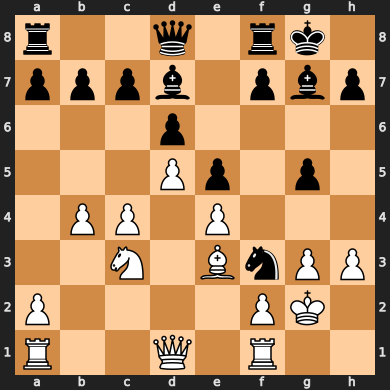

In [20]:
def disp(fen):
    board = chess.Board(fen)
    return board
disp(dataset["FEN"].iloc[801])

In [21]:
'''def tdleaf():
    input1 = tf.keras.Input(shape=(19))
    input2 = tf.keras.Input(shape=(64))
    input3 = tf.keras.Input(shape=(256))

    batch_1 = tf.keras.layers.BatchNormalization()(input1)
    batch_2 = tf.keras.layers.BatchNormalization()(input2)
    batch_3 = tf.keras.layers.BatchNormalization()(input3)

    in1_layer = tf.keras.layers.Dense(units=19, activation=tf.nn.relu)(batch_1)
    in2_layer = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(batch_2)
    in3_layer = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)(batch_3)

    concat_layer = tf.keras.layers.Concatenate()([in1_layer, in2_layer, in3_layer])

    hid1 = tf.keras.layers.Dense(units=92, activation=tf.nn.relu)(concat_layer)
    #hid2 = tf.keras.layers.Dense(units=96, activation=tf.nn.relu)(hid1)
    #hid3 = tf.keras.layers.Dense(units=5, activation=tf.nn.relu)(hid2)
    out = tf.keras.layers.Dense(units=1, activation=tf.nn.tanh)(hid1)

    model = tf.keras.Model(inputs=[input1, input2, input3], outputs=out)
    model.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=['accuracy'])
    model.summary()
    return model
eval_model = tdleaf()'''

"def tdleaf():\n    input1 = tf.keras.Input(shape=(19))\n    input2 = tf.keras.Input(shape=(64))\n    input3 = tf.keras.Input(shape=(256))\n\n    batch_1 = tf.keras.layers.BatchNormalization()(input1)\n    batch_2 = tf.keras.layers.BatchNormalization()(input2)\n    batch_3 = tf.keras.layers.BatchNormalization()(input3)\n\n    in1_layer = tf.keras.layers.Dense(units=19, activation=tf.nn.relu)(batch_1)\n    in2_layer = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(batch_2)\n    in3_layer = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)(batch_3)\n\n    concat_layer = tf.keras.layers.Concatenate()([in1_layer, in2_layer, in3_layer])\n\n    hid1 = tf.keras.layers.Dense(units=92, activation=tf.nn.relu)(concat_layer)\n    #hid2 = tf.keras.layers.Dense(units=96, activation=tf.nn.relu)(hid1)\n    #hid3 = tf.keras.layers.Dense(units=5, activation=tf.nn.relu)(hid2)\n    out = tf.keras.layers.Dense(units=1, activation=tf.nn.tanh)(hid1)\n\n    model = tf.keras.Model(inputs=[input1,

In [22]:
'''batch_size = 32
num_epochs = 2
learning_rate = 5e-4
td_len = 3

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = []

def step(x, y):
    def best_move(board, x, model):
        turn = int(board.turn==chess.WHITE)
        moves_set = board.legal_moves
        eval_set = []
        for move in moves_set:
            board.push(move)
            fen = board.fen()
            x1,x2,x3,y = feature_extract(fen)
            eval_set.append(model([x1,x2,x3]))
            board.pop()
        res = max(eval_set)
        bmove = moves_set[eval_set.index(res)]
        return bmove, res
             
    with tf.GradientTape() as tape:
        board = chess.Board(y[["FEN"]])
        prev_res = eval_model(x)
        loss = 0
        lmda = 0.7
        for move_td in range(td_len):
            bmove, res = best_move(board, x, eval_model)
            board.push(bmove)
            loss = lmda*loss+(res-prev_res)**2
            prev_res = res
    grads = tape.gradient(loss, eval_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, eval_model.trainable_variables))
    return loss

# The training loop!
for epoch in range(num_epochs):
  for idx in range(len(y_train)//batch_size):
    # Grab a batch of training data and propagate through the network
    x, y = [train1[idx*batch_size:idx*batch_size-1], train2[idx*batch_size:idx*batch_size-1], train3[idx*batch_size:idx*batch_size-1]], dataset[idx*batch_size:idx*batch_size-1]
    loss = eval_model(x, y)
    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())

loss_history'''


'batch_size = 32\nnum_epochs = 2\nlearning_rate = 5e-4\ntd_len = 3\n\noptimizer = tf.keras.optimizers.Adam(learning_rate)\nloss_history = []\n\ndef step(x, y):\n    def best_move(board, x, model):\n        turn = int(board.turn==chess.WHITE)\n        moves_set = board.legal_moves\n        eval_set = []\n        for move in moves_set:\n            board.push(move)\n            fen = board.fen()\n            x1,x2,x3,y = feature_extract(fen)\n            eval_set.append(model([x1,x2,x3]))\n            board.pop()\n        res = max(eval_set)\n        bmove = moves_set[eval_set.index(res)]\n        return bmove, res\n             \n    with tf.GradientTape() as tape:\n        board = chess.Board(y[["FEN"]])\n        prev_res = eval_model(x)\n        loss = 0\n        lmda = 0.7\n        for move_td in range(td_len):\n            bmove, res = best_move(board, x, eval_model)\n            board.push(bmove)\n            loss = lmda*loss+(res-prev_res)**2\n            prev_res = res\n    grads

In [23]:
def feat_ex(fen):
    f_centric = features_piece(fen)
    f_global = features_global(fen)
    f_map = features_map(fen)
    f_global.extend(f_centric[:14])
    f_centric=f_centric[14:]
    return [f_global], [f_centric], [f_map]

In [24]:
fe = "2q1rrk1/1b2ppbp/p2p1np1/P1pP4/2B1PP2/2NQ3P/1P1B2P1/R4RK1 w - - 5 22"
boar = chess.Board(fe)
l1,l2,l3 = feat_ex(fe)
l3 = np.array(l3).reshape(1,4, 8, 8)
(l1,l2,l3) = (tens(l) for l in (l1,l2,l3))
float(model.predict([l1,l2,l3]).flatten())

1/1 [==============================] - 0s 105ms/step


0.0026919154915958643

In [25]:
l3

<tf.Tensor: shape=(1, 4, 8, 8), dtype=float64, numpy=
array([[[[1., 4., 3., 3., 3., 3., 1., 1.],
         [3., 0., 1., 1., 2., 2., 1., 1.],
         [2., 1., 3., 1., 2., 3., 1., 2.],
         [2., 0., 1., 1., 2., 2., 1., 0.],
         [1., 2., 0., 4., 1., 1., 1., 0.],
         [1., 1., 1., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[5., 3., 3., 3., 3., 1., 5., 1.],
         [3., 0., 9., 9., 3., 1., 1., 1.],
         [1., 3., 1., 3., 3., 1., 9., 1.],
         [3., 0., 9., 9., 3., 3., 1., 0.],
         [5., 3., 0., 1., 1., 1., 1., 0.],
         [3., 1., 1., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 1., 1., 0., 2., 0.],
         [0., 1., 2., 2., 1., 2., 0., 2.],
         [1., 0., 2., 1., 2., 2., 2., 1

In [26]:
def mod(arr):
    return [0.01]


In [27]:
from chessboard import display
import chess

pygame 2.1.2 (SDL 2.0.18, Python 3.10.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [29]:
over=False
board = chess.Board()
game_board = display.start()
while(over==False):
    display.check_for_quit()
    mov = input("Move: ").strip()
    try:
        Move = board.parse_san(mov)#chess.Move.from_uci(mov)
    except:
        print("Wrong Move: "+mov)
        continue
    if Move not in board.legal_moves:
        print("RETRY")
        continue
    board.push(Move)
    display.update(board.fen(), game_board)
    if(board.outcome()!=None):
        if(board.outcome().result()=="1-0"):
            print("YOU WIN")
            break
        elif(board.outcome().result()=="0-1"):
            print("YOU LOSE")
            break
        elif(board.outcome().result()=="1/2-1/2"):
            print("DRAW")
            break
    b_move = board.legal_moves
    b_move2 = []
    b_eval =[]
    for m in b_move:
        board.push(m)
        '''
        l1,l2,l3, ly = feature_extract(pd.DataFrame({"FEN": [board.fen()], "Evaluation": [0]}))
        l3 = np.array(l3).reshape(len(ly), 4, 8, 8)
        (l1,l2,l3, ly) = (tens(l) for l in (l1,l2,l3, ly))
        b_eval.append(float(model.predict([l1,l2,l3]).flatten()))'''
        l1,l2,l3 = feat_ex(board.fen())
        l3 = np.array(l3).reshape(1,4, 8, 8)
        (l1,l2,l3) = (tens(l) for l in (l1,l2,l3))
        b_eval.append(float(model.predict([l1,l2,l3]).flatten()))
        #b_eval.append(11.5)
        b_move2.append(m)
        board.pop()
    Move = b_move2[b_eval.index(max(b_eval))]
    board.push(Move)
    display.update(board.fen(), game_board)
    if(board.outcome()!=None):
        if(board.outcome().result()=="1-0"):
            print("YOU WIN")
            break
        elif(board.outcome().result()=="0-1"):
            print("YOU LOSE")
            break
        elif(board.outcome().result()=="1/2-1/2"):
            print("DRAW")
            break
display.terminate()
#game()

1/1 [==============================] - 0s 17ms/step
Wrong Move: Bf3
1/1 [==============================] - 0s 18ms/step
Wrong Move: B27
1/1 [==============================] - 0s 15ms/step
Wrong Move: Kc3
Wrong Move: Kc1
Wrong Move: Kc1
1/1 [==============================] - 0s 16ms/step
YOU WIN


SystemExit: 

d:\Programs\Python\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
